![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with SHAP for Multi-Class Classifications

In this Notebook we will demonstrate how to use the SHapley Additive exPlanations (SHAP) method and interpret its results for multi-class classification models.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/master/xai-model-agnostic/Tutorial_SHAP_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Now that you are visualizing the notebook in Colab, run the next cell to install the packages we will use.
There are few things you should follow in order to properly set the notebook up:

1. Warning: This notebook was not authored by Google. *Click* on 'Run anyway'.
2. When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, *click* it. 

In [ ]:
# %pip install shap

By running the next cell you are going to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:
1. Permit this notebook to access your Google Drive files? *Click* on 'Yes', and select your account.
2. Google Drive for desktop wants to access your Google Account. *Click* on 'Allow'.

At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive. 

In [ ]:
# Create a folder in your Google Drive
# from google.colab import drive                                                                          
# drive.mount('/content/drive')

In [ ]:
# Don't run this cell if you already cloned the repo 
# !git clone https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [ ]:
# %cd XAI-Tutorials/xai-model-agnostic

### Imports

Let's start with importing all required Python packages.

In [ ]:
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Now, we fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [ ]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## The Wine dataset: Data and Model Loading

Let's use the wine quality dataset to see how SHAP can be used to explain multi-class classification models. The **Wine Recognition dataset** contains 178 wine samples from three different cultivators of wine in the same region in Italy. The wine was chemically analysed and 13 different chemical attributes like *alcohol*, *malic acid*, *flavanoids* etc were measured. Our goal is to **classify wines** and find the most predictive features.

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_red_wine.jpg?raw=true" width="900" /></center>

<font size=1> Source:
[Link](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)

In the notebook [*Dataset-Wine.ipynb*](../data_and_models/Dataset-Wine.ipynb), we explain how to do the exploratory data analysis, preprocess the data and in the notebook [*Model-RandomForest.ipynb*](../data_and_models/Model-RandomForest.ipynb) we train a Random Forest model with the given data. The focus of this notebook lies on the interpretation of the trained model and not on the data pre-processing or model training part. Hence, here we simply load the data and the model that we saved in the previous notebook.

In [ ]:
# Load and unpack the data
data_and_model = joblib.load(open('../data_and_models/model_randomforest_wine.joblib', 'rb'))
X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
rf = data_and_model[4]

X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-1.239078,-0.767092,0.236050,0.742035,-0.923955,-1.289817,-0.727069,1.115309,0.115029,-0.604872,0.394721,0.085734,-0.973430
1,-0.340168,-0.509581,-0.553479,-0.219964,-0.923955,-0.098442,0.545827,-0.890482,0.355235,-0.477038,0.874379,0.772194,-0.090297
2,-1.139199,-0.870096,0.523152,0.892347,-1.068053,0.473418,0.307159,0.530287,-0.897271,-0.903152,-0.128544,0.842241,-1.190868
3,1.382742,-0.329323,0.164275,-0.219964,0.300881,0.775232,0.933662,-0.389034,1.401850,0.503025,0.481931,0.225827,1.067142
4,0.933287,-0.629753,-0.374041,-0.941463,1.381619,0.536957,0.913773,-1.308355,0.097871,0.353885,-0.172149,0.856250,1.067142


Check again how the model performed on train and test set.

In [ ]:
# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(rf.score(X_train, y_train)*100,2)} % accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(rf.score(X_test, y_test)*100,2)} % accuracy.')

Model Performance on training data: 100.0 % accuracy.
Model Performance on test data: 97.22 % accuracy.


As we can see by the numbers above, our model performs perfectly on the training set and also generalizes great to the independent test set.

*Note: you should keep in mind that interpreting a low performing model can lead to wrong conclusions.*

## Now, what does my model actually think is important in the data?

We prepared a small [Introduction to SHAP](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html) for you, to help you understand how this method works.

Now lets use SHAP to get some insights into the Random Forest Classification model we loaded above. The `shap.Explainer()` function uses the shap values to explain any machine learning model. Since our model is a Random Forest model, we use TreeSHAP (`shap.TreeExplainer()`), which calculates Shapley values for tree-based methods in a fast and model-specific way. Please refer to the [SHAP API](https://shap.readthedocs.io/en/latest/api.html#explainers) for alternative explainers.

One major difference when analysing multi-class classification models with SHAP, compared to binary classification or regression models, is that we will get one shapley value matrix and expected value per class. Hence, in our case we will get three SHAP value matrices and expected values because we have three classes of wines. The order of the SHAP value matrices and expected value output is the same as the sorting of the target classes.

*Note: this method is a **local** method which means that it does only provide explanations for individual samples. However, the individual explanations can be used to also get **global** interpretations.*

In [ ]:
# run SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_train)

In [ ]:
# get original unscaled feature values
scaler = data_and_model[5]
X_train_unscaled = scaler.inverse_transform(X_train)
X_train_unscaled = pd.DataFrame(X_train_unscaled, columns = X_train.columns)
shap_values.data = X_train_unscaled

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

For our multiclass classification task shap explainer produces three expected values, corresponding to the average probability for each class, which is essentially the class frequency in the dataset.

In [ ]:
# average prediction for the dataset
ev = explainer.expected_value
print(f'Models average prediction for our data set is for class 0: {round(ev[0],3)}, for class 1: {round(ev[1],3)}, for class 2: {round(ev[2],3)}')

Models average prediction for our data set is for class 0: 0.319, for class 1: 0.406, for class 2: 0.275


### Local Explanations

Since we have three shapley value matrices, we will have to visualize the local explanations seperately for each class.

In [ ]:
observation_of_interest = 5
print(f'Class for observation of interest: {y_train[observation_of_interest]}; and models prediction for the observation of interest: {rf.predict(X_train)[observation_of_interest]}')

Class for observation of interest: 1; and models prediction for the observation of interest: 1


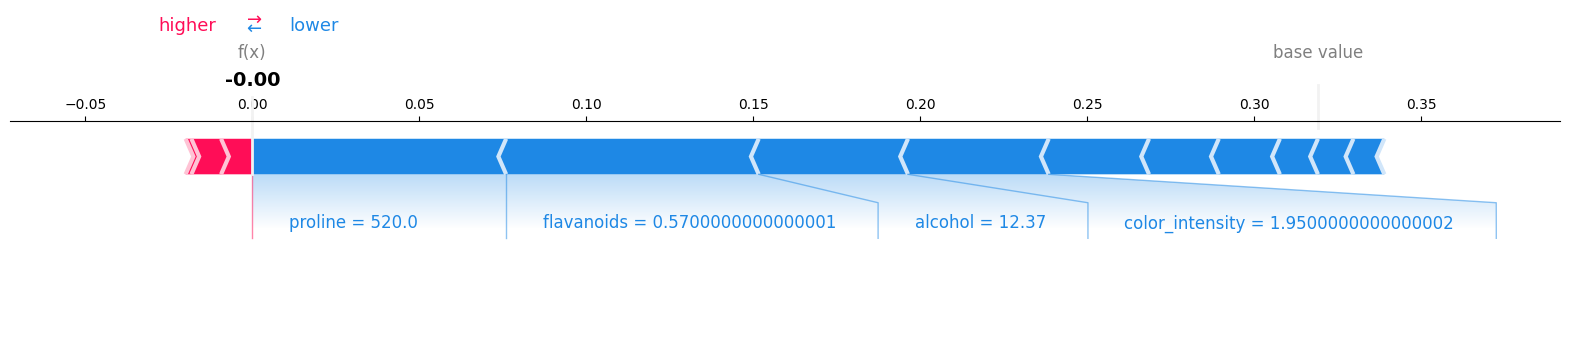

In [ ]:
# force plot for class 0
target_class = 0
shap.force_plot(
    explainer.expected_value[target_class], 
    shap_values.values[target_class][observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], 
    matplotlib=True)

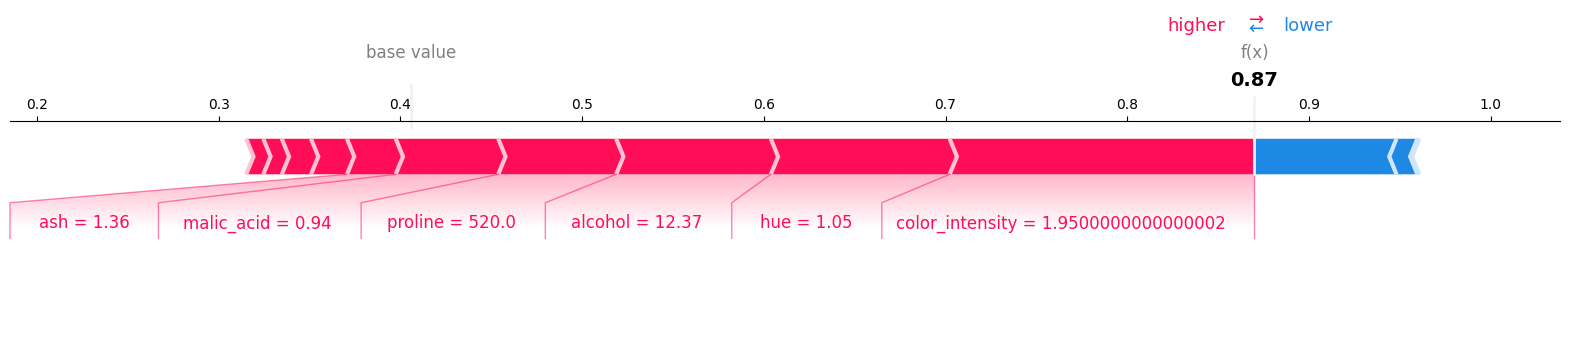

In [ ]:
# force plot for class 1
target_class = 1
shap.force_plot(
    explainer.expected_value[target_class], 
    shap_values.values[target_class][observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], 
    matplotlib=True)

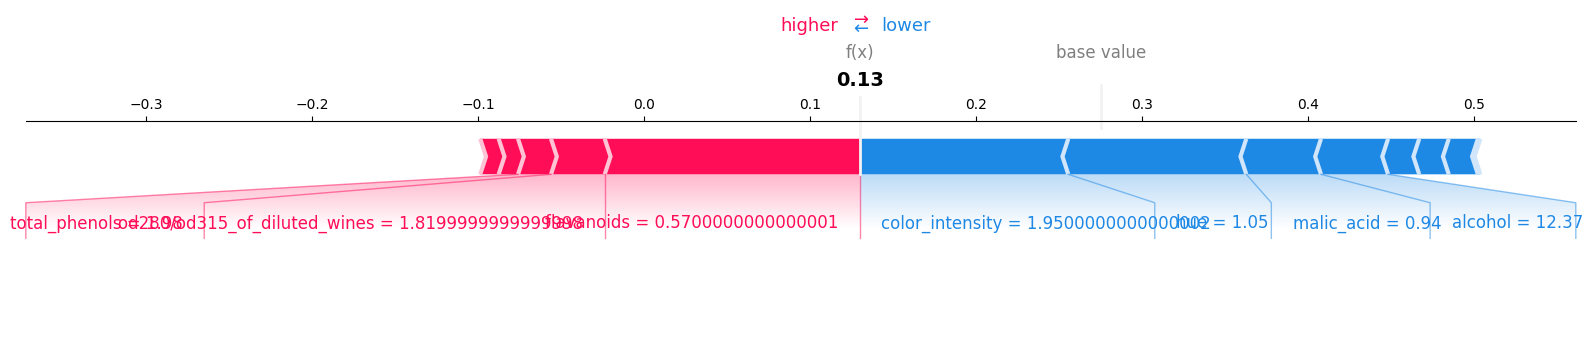

In [ ]:
# force plot for class 2
target_class = 2
shap.force_plot(
    explainer.expected_value[target_class], 
    shap_values.values[target_class][observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], 
    matplotlib=True)

The average probability for each class is labeled as the *base value* in the respective plots (0.32 for class 0, 0.40, for class 1 and 0.2for class 2). The predicted wine class probability for the observation of interest is labeled as the *f(x)*.

Comparing the three plots above, we can see that our observation of interest has a high probability of belonging to class 1 (probability = 0.87), while it has a low probability of belong to class 0 (probability = 0) or class 2 (probability = 0.13). 

Furthermore, we can see which feature contribute to a low or high class probability:
- class 0: the proline and flavanoids values highly lower the probability for this class
- class 1: the color intensity value highly increases the probability for this class
- class 2: the color intensity and hue value highly lowers the probability for this class

### Global Explanations

For the global explanations we can visualize a combined bar plot that shows the average absolute SHAP values stacked per class.

*Note: the shap.plots.bar() fucntion of the new package does currently not work for multi-class classiciation problem. Instaed we have to use the old shap.summary_plot() function.*

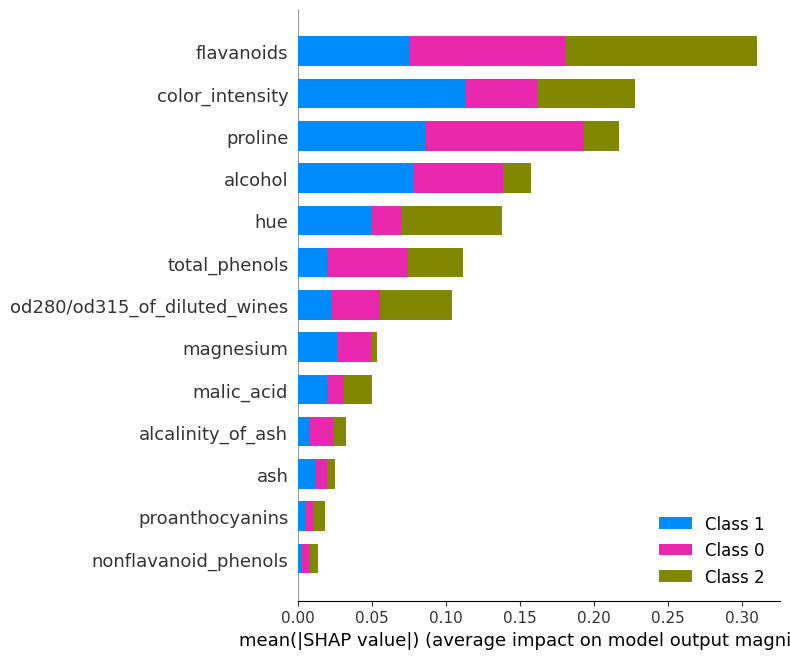

In [ ]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')

When we want to visualize the SHAP value summary as a beeswarm or violin plot, we have to do the visualization class-wise again.

*Note: the shap.plots.beeswarm() fucntion of the new package does currently not work for multi-class classiciation problem. Instaed we have to use the old shap.summary_plot() function. For the violin plot, we have to manually select the dimension of interest.*

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


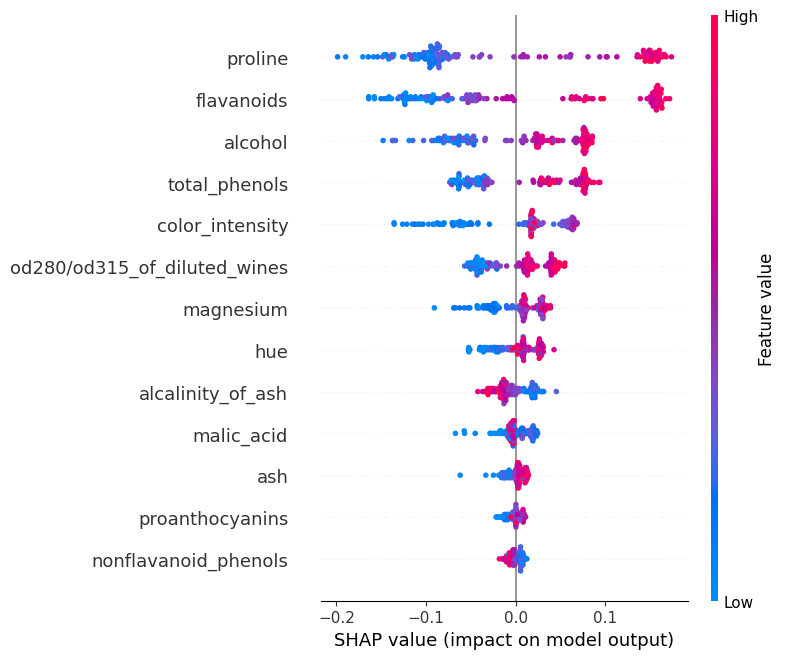

In [ ]:
# summary plot for class 0
target_class = 0
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

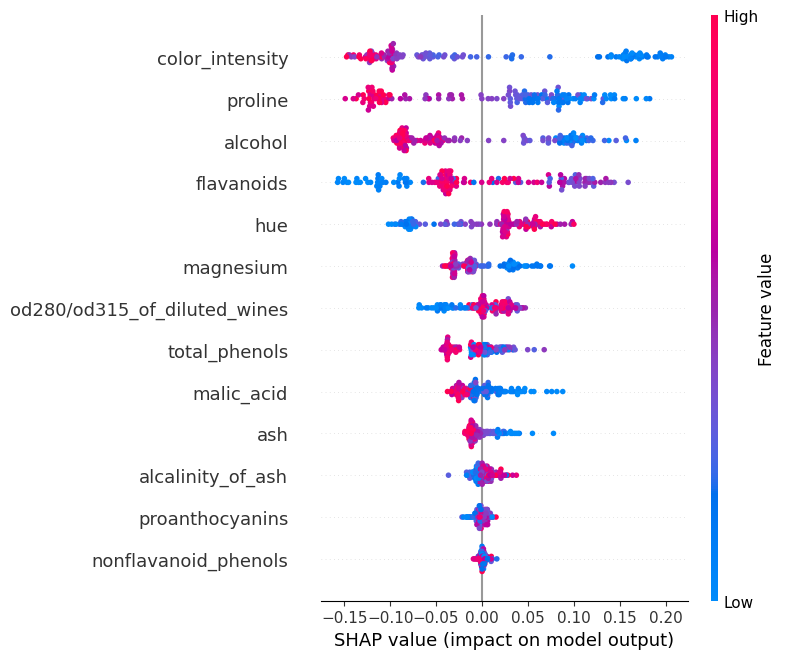

In [ ]:
# summary plot for class 1
target_class = 1
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

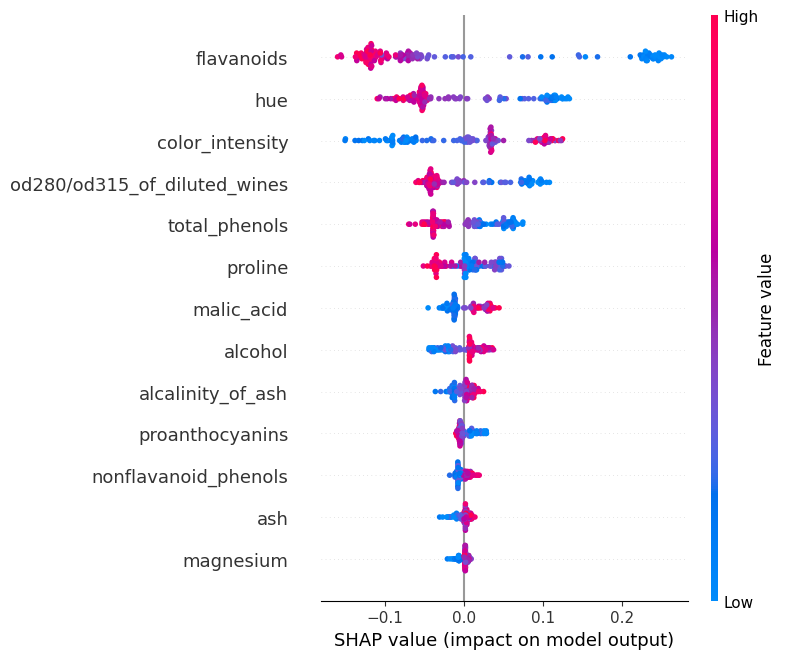

In [ ]:
# summary plot for class 2
target_class = 2
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


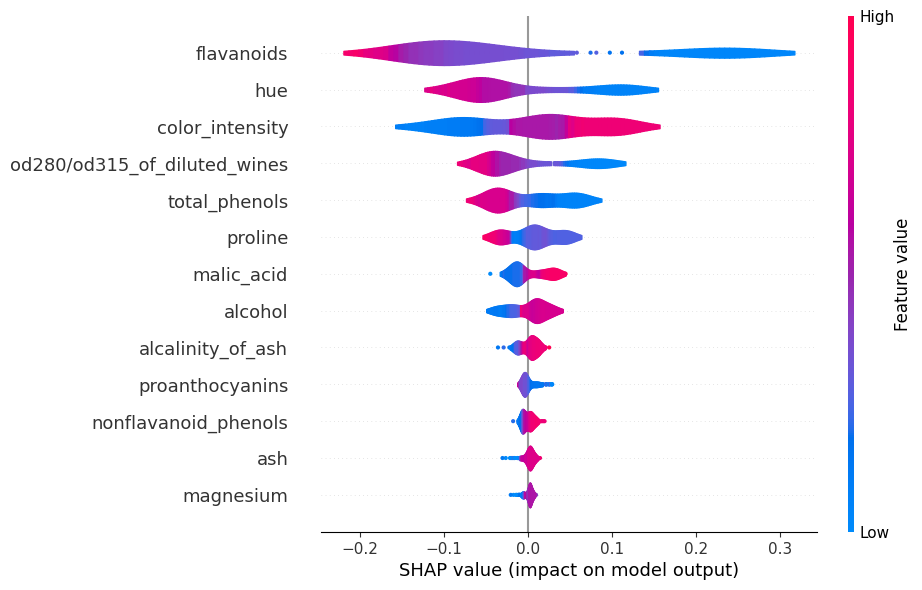

In [ ]:
shap_values_all_values = shap_values.values
shap_values.values = shap_values.values[target_class]

shap.plots.violin(shap_values)

shap_values.values = shap_values_all_values

From the plots above, we can see for instance that:

- high proline, flavanoids and alcohol values increase the probability for class 0 wines
- low color intensity, proline and alcohol values increases the probability for class 1 wines
- low flavanoids and hue but high color intensity values increase the probability for class 2 wines